# Data Save/Loading (Materializers) Notebook 

This notebook shows some code on how to save & load data with hamilton.

This is more a notebook to show the mechanics, rather than proper applicability of the approach.

In [1]:
from hamilton import base
from hamilton import driver
from hamilton.io.materialization import from_, to

import pandas as pd
# load some extensions / magic...
%load_ext hamilton.plugins.jupyter_magic
# load extension
%load_ext autoreload
# configure autoreload to only affect specified files
%autoreload 1

# Saving Data

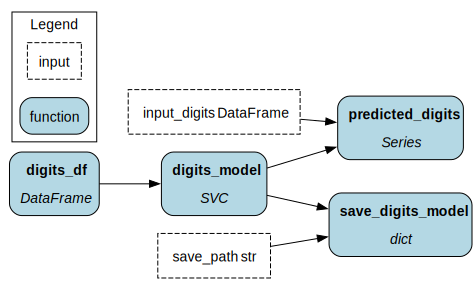

In [2]:
%%cell_to_module -m saving_data --display
from sklearn import datasets
from sklearn import svm
import pickle

import pandas as pd

def digits_df() -> pd.DataFrame:
    """Load the digits dataset."""
    digits = datasets.load_digits()
    _digits_df = pd.DataFrame(digits.data) 
    _digits_df["target"] = digits.target
    return _digits_df

def digits_model(digits_df: pd.DataFrame) -> svm.SVC:
    """Train a model on the digits dataset."""
    clf = svm.SVC(gamma=0.001, C=100.)
    _digits_model = clf.fit(
          digits_df.drop('target', axis=1), 
          digits_df.target
    )
    return _digits_model

def predicted_digits(
       digits_model: svm.SVC, 
       input_digits: pd.DataFrame) -> pd.Series:
    """Predict the digits."""
    return pd.Series(digits_model.predict(input_digits))

def save_digits_model(digits_model: svm.SVC, save_path: str) -> dict:
    pickle.dump(digits_model, save_path)
    return {"some_metadata": "saved_size"}

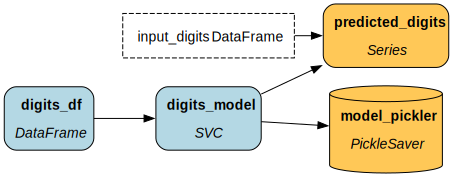

In [3]:
# here you'd just execute
from sklearn import datasets
dr_saving = (
    driver.Builder()
    .with_modules(saving_data)
    .with_adapters(base.PandasDataFrameResult())
    .build()
)

dr_saving.visualize_materialization(
    to.pickle( # saves output of `digits_model`
        id="model_pickler",
        dependencies=["digits_model"],
        path="./model.pkl"
    ),
    additional_vars=["predicted_digits"],
    inputs={"input_digits": None},
 orient="LR",
 show_legend=False,
)

# Using @save_to

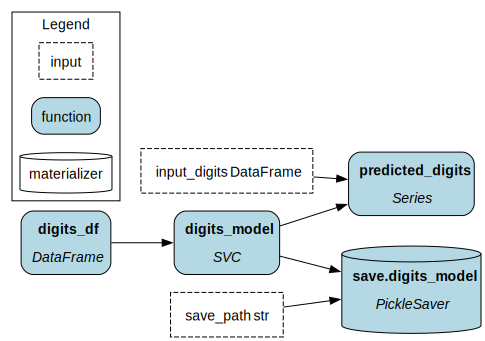

In [4]:
%%cell_to_module -m saving_data_function --display
from sklearn import datasets
from sklearn import svm
import pickle
from hamilton.function_modifiers import save_to, source
import pandas as pd

def digits_df() -> pd.DataFrame:
    """Load the digits dataset."""
    digits = datasets.load_digits()
    _digits_df = pd.DataFrame(digits.data) 
    _digits_df["target"] = digits.target
    return _digits_df

@save_to.pickle(path=source("save_path"))
def digits_model(digits_df: pd.DataFrame) -> svm.SVC:
    """Train a model on the digits dataset."""
    clf = svm.SVC(gamma=0.001, C=100.)
    _digits_model = clf.fit(
          digits_df.drop('target', axis=1), 
          digits_df.target
    )
    return _digits_model

def predicted_digits(
       digits_model: svm.SVC, 
       input_digits: pd.DataFrame) -> pd.Series:
    """Predict the digits."""
    return pd.Series(digits_model.predict(input_digits))

# Loading Data

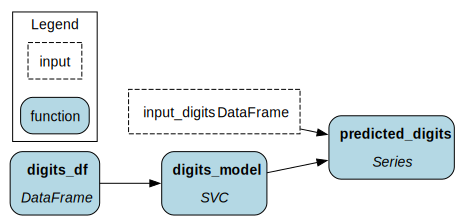

In [5]:
%%cell_to_module -m loading_data --display
from sklearn import datasets
from sklearn import svm

import pandas as pd


def digits_df() -> pd.DataFrame:
    """Load the digits dataset."""
    digits = datasets.load_digits()
    _digits_df = pd.DataFrame(digits.data) 
    _digits_df["target"] = digits.target
    return _digits_df

def digits_model(digits_df: pd.DataFrame) -> svm.SVC:
    """Train a model on the digits dataset."""
    clf = svm.SVC(gamma=0.001, C=100.)
    _digits_model = clf.fit(
          digits_df.drop('target', axis=1), 
          digits_df.target
    )
    return _digits_model

def predicted_digits(
       digits_model: svm.SVC, 
       input_digits: pd.DataFrame) -> pd.Series:
    """Predict the digits."""
    return pd.Series(digits_model.predict(input_digits))

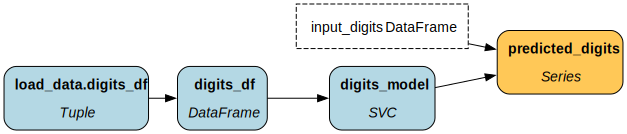

In [6]:
from sklearn import datasets
dr_simple = (
    driver.Builder()
    .with_modules(loading_data)
    .with_adapters(base.PandasDataFrameResult())
    .build()
)

dr_simple.visualize_materialization(
    # replaces `digits_df`
    from_.csv(
        target="digits_df",
        path="./input.csv"
    ),
    additional_vars=["predicted_digits"],
    inputs={"input_digits": None},
 orient="LR",
 show_legend=False,
)

# Using `@load_from`

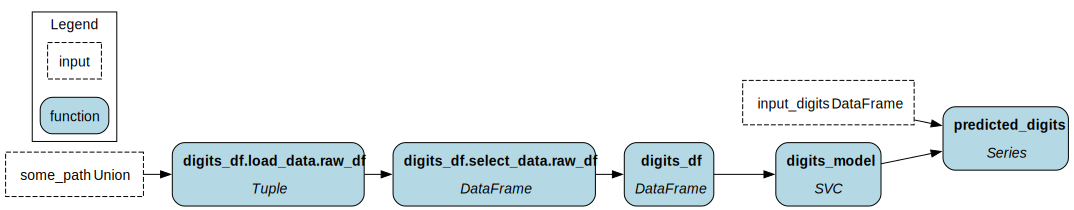

In [7]:
%%cell_to_module -m loading_data_function --display
from sklearn import datasets
from sklearn import svm

import pandas as pd

from hamilton.function_modifiers import load_from, source

@load_from.csv(path=source("some_path"))
def digits_df(raw_df: pd.DataFrame) -> pd.DataFrame:
    """Do any final adjustments to the digits dataset."""
    raw_df["target"] = "..."
    return raw_df

def digits_model(digits_df: pd.DataFrame) -> svm.SVC:
    """Train a model on the digits dataset."""
    clf = svm.SVC(gamma=0.001, C=100.)
    _digits_model = clf.fit(
          digits_df.drop('target', axis=1), 
          digits_df.target
    )
    return _digits_model

def predicted_digits(
       digits_model: svm.SVC, 
       input_digits: pd.DataFrame) -> pd.Series:
    """Predict the digits."""
    return pd.Series(digits_model.predict(input_digits))

# Custom Classes
It's easy to create your own data save or data loader!

## Custom Saver

In [8]:
import dataclasses
import pickle
from typing import Any, Collection, Dict, Type

import numpy as np

from hamilton import registry
from hamilton.io import utils
from hamilton.io.data_adapters import DataSaver


@dataclasses.dataclass
class SKLearnPickler(DataSaver):
    path: str

    def save_data(self, data: svm.SVC) -> Dict[str, Any]:
        pickle.dump(data, open(self.path, "wb"))
        return utils.get_file_metadata(self.path)

    @classmethod
    def applicable_types(cls) -> Collection[Type]:
        return [svm.SVC]

    @classmethod
    def name(cls) -> str:
        return "pickle"


for adapter in [SKLearnPickler]:
    registry.register_adapter(adapter)


More than one applicable adapter detected for <class 'sklearn.svm._classes.SVC'>. Using the last one registered <class '__main__.SKLearnPickler'>.


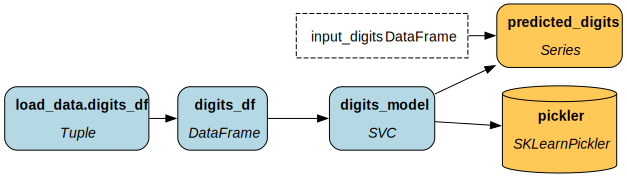

In [9]:
dr_custom = (
    driver.Builder()
    .with_modules(loading_data)
    .with_adapters(base.PandasDataFrameResult())
    .build()
)

dr_custom.visualize_materialization(
    from_.csv(  # replaces `digits_df`
        target="digits_df",
        path="./input.csv",
    ),
    to.pickle(  # saves digits_model
        id="pickler",
        dependencies=["digits_model"],
        path="./output.pkl",
    ),
    additional_vars=["predicted_digits"],
    inputs={"input_digits": None},
    orient="LR",
    show_legend=False,
)

## Custom loader

In [11]:
import dataclasses
import pickle
from typing import Any, Collection, Dict, Type, Tuple
import pandas as pd

from hamilton import registry
from hamilton.io import utils
from hamilton.io.data_adapters import DataSaver, DataLoader


@dataclasses.dataclass
class MyCustomDataLoader(DataLoader):
    table_name: str
    other_config: str

    def __post_init__(self):
        self.connection = object() # do something fancy

    @classmethod
    def applicable_types(cls) -> Collection[Type]:
        return [pd.DataFrame]

    def load_data(self, type_: Type) -> Tuple[pd.DataFrame, Dict[str, Any]]:
        # Do your custom logic here; here's some pseudo code:
        raw_df = self.connection(self.table_name)
        # validate things here
        validate(raw_df)
        # do anything else you need
        return raw_df, metadata(raw_df) 

    @classmethod
    def name(cls) -> str:
        return "prod_db"


for adapter in [MyCustomDataLoader]:
    registry.register_adapter(adapter)

More than one applicable adapter detected for <class 'sklearn.svm._classes.SVC'>. Using the last one registered <class '__main__.SKLearnPickler'>.


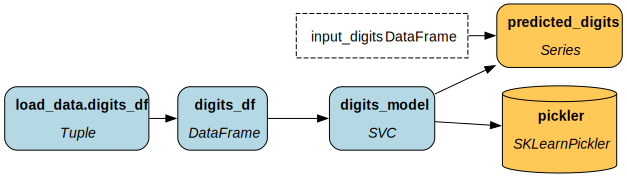

In [12]:
dr_custom = (
    driver.Builder()
    .with_modules(loading_data)
    .with_adapters(base.PandasDataFrameResult())
    .build()
)

dr_custom.visualize_materialization(
    from_.prod_db(  # replaces `digits_df`
        target="digits_df",
        table_name="foo_bar",
        other_config="some_other_value",
    ),
    to.pickle(  # saves digits_model
        id="pickler",
        dependencies=["digits_model"],
        path="./output.pkl",
    ),
    additional_vars=["predicted_digits"],
    inputs={"input_digits": None},
    orient="LR",
    show_legend=False,
)